In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import copy
import tensorflow as tf

import os
import time
import numpy as np
from IPython.display import clear_output
import sys
import csv
import math
from matplotlib import colors
import fcn32_new as fcn32_vgg
import csv
ckpt_dir = "/mnt/data1/fcn/ckpt_dir"
PRETRAINED_MODEL_PATH= "/mnt/data1/fcn/ckpt_dir"
LOGS_PATH = '/home/sik4hi/tensorflow_logs'
WEIGHT_PATH = '.npy'
TRAINSET_PATH = '/mnt/data1/city/csv_files/cityscapes_train_wmask.csv'
VALSET_PATH = '/mnt/data1/city/csv_files/cityscapes_val_wmask.csv'

NUM_OF_CLASSESS = 19
BATCH_SIZE = 1
IMAGE_HEIGHT = 1024
IMAGE_WIDTH = 2048
NUM_CHANNELS = 3
N_EPOCHS = 1

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
f=open(VALSET_PATH,"r")
filepaths=[]
labels=[]
masks=[]
for line in f:
    filepath, label, mask= line.split(",")
    filepaths.append(filepath)
    labels.append(label)
    masks.append(mask.split("\r")[0])
    
one_ex = tf.train.slice_input_producer([filepaths,labels, masks]
                                           ,capacity = 500)
#csv_path = tf.train.string_input_producer([TRAINSET_PATH])
#textReader = tf.TextLineReader()
#_, content = textReader.read(csv_path)
#one_ex = tf.decode_csv(content, record_defaults=[[""], [""], [""]])

im_content = tf.read_file(one_ex[0])
train_image = tf.image.decode_png(im_content, channels=3)
train_image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS])
train_image = tf.cast(train_image, tf.float32)

la_content = tf.read_file(one_ex[1])
label_image = tf.image.decode_png(la_content, channels=1)
label_image.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, 1])
label_image=tf.squeeze(label_image, squeeze_dims=[2])

#record_bytes=2097152
#reader=tf.FixedLengthRecordReader(record_bytes)
value =tf.read_file(one_ex[2])
mask=tf.decode_raw(value,tf.uint8)
mask.set_shape([2097152])
#mask=tf.cast(mask, tf.float32)




train_image_batch, train_label_batch, train_mask_batch= tf.train.batch([train_image, label_image, mask], batch_size=BATCH_SIZE,
                                                               capacity=100 + 3 * BATCH_SIZE,
                                                               num_threads=7)
with tf.device('/gpu:0'):
    sess = tf.Session()
    #images_tf = tf.placeholder(tf.float32,[None, 1024, 2048, 3])
    #labels_tf = tf.placeholder(tf.int32,[None, 1024, 2048])
    #weights = tf.placeholder(tf.float32,[None, 1024, 2048])

    vgg_fcn = fcn32_vgg.FCN32VGG('./vgg16.npy')
    with tf.name_scope("content_vgg"):
        vgg_fcn.build(train_image_batch, train=False, num_classes=19, random_init_fc8=True, debug=False)


    #head=[]
    #sum_of_weights=tf.reduce_sum(weights)
    #labels_oh= tf.one_hot(labels_tf,19)
    labels_tf_flat=tf.reshape(tf.mul(tf.reshape(train_label_batch,[-1]),train_mask_batch),[-1])
    mask2=tf.reshape(train_mask_batch,[1024,2048])
    #labels_tf_flat2= tf.gather(labels_tf_flat,tf.where(tf.not_equal(labels_tf_flat,19))[1])
    logits = tf.reshape(vgg_fcn.upscore, (-1, NUM_OF_CLASSESS))
    #logits = tf.gather(logits,tf.where(tf.not_equal(labels_tf_flat,19)))
    labels_tf_flat = tf.cast(labels_tf_flat, tf.int32)

    #epsilon = tf.constant(value=1e-4)
    #logits = logits + epsilon
    #labels_flat_sparse = tf.reshape(labels_oh, (-1, NUM_OF_CLASSESS))
    #labels_flat_sparse=tf.cast(labels_flat_sparse, tf.float64)
    #ww_flat=tf.reshape(weights,[-1])
    #ww_flat = tf.cast(ww_flat, tf.float64)
    #softmax = tf.nn.softmax(logits)
    #softmax = tf.cast(softmax, tf.float64)
    #test1=-tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1])
    #test2=tf.reduce_sum(test1)
    #cross_entropy = tf.mul(-tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1]),ww_flat)
    #cross_entropy = -tf.reduce_sum(labels_flat_sparse * tf.log(softmax), reduction_indices=[1])
    #mask_flat=tf.reshape(train_mask_batch,[-1])
    train_mask_batch=tf.cast(train_mask_batch, tf.float32)
    cross_entropy =tf.mul(tf.nn.sparse_softmax_cross_entropy_with_logits(logits,labels_tf_flat),train_mask_batch)
    #cross_entropy_sum= tf.reduce_sum(cross_entropy,
    #                                name='xentropy_mean')
    #cross_entropy_mean = tf.reduce_mean(cross_entropy,name='xentropy_mean')
    #cross_entropy_mean = cross_entropy_sum/tf.cast(sum_of_weights, tf.float32)
    cross_entropy_mean = tf.reduce_mean(cross_entropy,
                                        name='xentropy_mean')
    l2_loss=tf.reduce_sum(tf.get_collection("losses"))
    total_loss=cross_entropy_mean +l2_loss
    #loss_tf = tf.reduce_mean((tf.nn.sparse_softmax_cross_entropy_with_logits(vgg_fcn.upscore,
     #                                                                     tf.squeeze(labels_tf, squeeze_dims=[3]),
      #                                                                    name="entropy")))
    
    
    
    
    #train_op = tf.train.MomentumOptimizer(0.0001, 0.99).minimize(cross_entropy_mean)
    #train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(total_loss)
    predictions=tf.argmax(logits, 1)
    #labels_tf_flat=tf.reshape(labels_tf_flat,[-1])
    #labels_flat=tf.cast(labels_tf_flat, tf.int64)
    pred_flat=tf.reshape(predictions,[-1])
with tf.device('/cpu:0'):
    miou=tf.contrib.metrics.streaming_mean_iou(pred_flat,labels_tf_flat,19,weights=train_mask_batch)
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    saver = tf.train.Saver(max_to_keep=10)
with tf.device('/gpu:0'):
    print('Finished building Network.')
    
    init_op = tf.group(tf.initialize_all_variables(),
                       tf.initialize_local_variables())
    sess.run(init_op)
        
    if PRETRAINED_MODEL_PATH:
        print "using Pretrained model"
        ckpt = tf.train.get_checkpoint_state(PRETRAINED_MODEL_PATH)
        print(ckpt)
        saver.restore(sess,ckpt.model_checkpoint_path)
        
    # print(csv_path)
    # For populating queues with batches, very important!
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    print("finished")

Model Loaded
conv1_1 Value Loaded
Layer name: conv1_1
Layer shape: (3, 3, 3, 64)
conv1_1 Frozen
conv1_1 (64,) Value Loaded


conv1_2 Value Loaded
Layer name: conv1_2
Layer shape: (3, 3, 64, 64)
conv1_2 Frozen
conv1_2 (64,) Value Loaded


conv2_1 Value Loaded
Layer name: conv2_1
Layer shape: (3, 3, 64, 128)
L2 Loss Added
conv2_1 (128,) Value Loaded


conv2_2 Value Loaded
Layer name: conv2_2
Layer shape: (3, 3, 128, 128)
L2 Loss Added
conv2_2 (128,) Value Loaded


conv3_1 Value Loaded
Layer name: conv3_1
Layer shape: (3, 3, 128, 256)
L2 Loss Added
conv3_1 (256,) Value Loaded


conv3_2 Value Loaded
Layer name: conv3_2
Layer shape: (3, 3, 256, 256)
L2 Loss Added
conv3_2 (256,) Value Loaded


conv3_3 Value Loaded
Layer name: conv3_3
Layer shape: (3, 3, 256, 256)
L2 Loss Added
conv3_3 (256,) Value Loaded


conv4_1 Value Loaded
Layer name: conv4_1
Layer shape: (3, 3, 256, 512)
L2 Loss Added
conv4_1 (512,) Value Loaded


conv4_2 Value Loaded
Layer name: conv4_2
Layer shape: (3, 3, 512, 512)
L2

In [2]:
epoch = 0

===========**Training ACCURACY**================
Epoch 2
Training mIOU:  0.457574
Training Loss: 0.264172
Training Loss: 0.326454
Time Elapsed for Epoch:1 is 2.95912611485 minutes


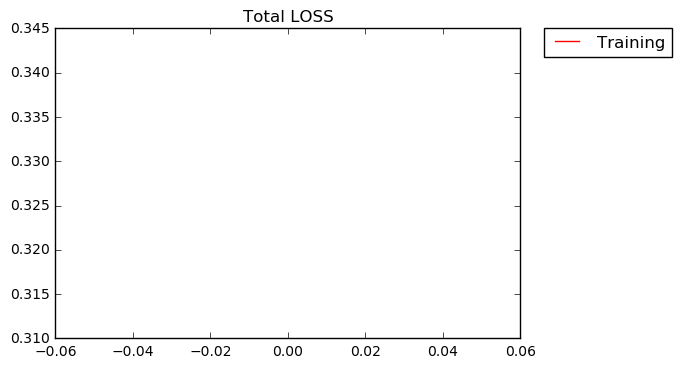

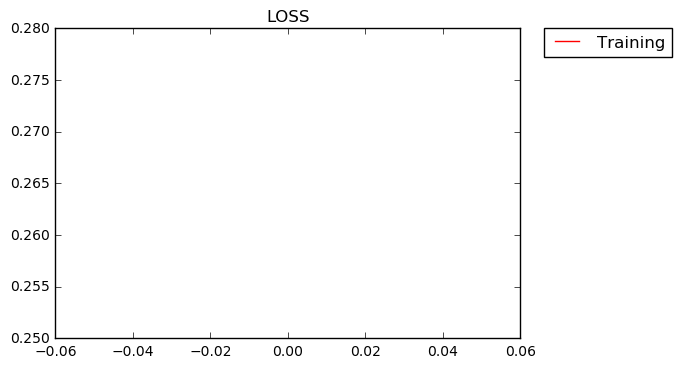

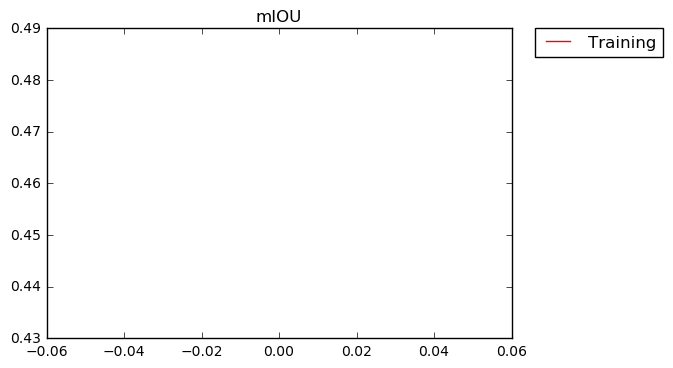

requesting stop


In [3]:
total_train_loss_list,train_loss_list,plot_train_loss,plot_total_train_loss,plot_miou,loss= [],[],[],[],[],0
#for epoch in xrange(N_EPOCHS):
cmap = colors.ListedColormap(['blue','lightblue','orange','purple','r'
                              ,'darkkhaki','yellow','saddlebrown','orchid','grey'
                              ,'hotpink','blueviolet','gold','deeppink','greenyellow'
                              ,'maroon','yellowgreen','green','orangered','black'])
norm=colors.NoNorm(0,19)
try:
    while not coord.should_stop() and epoch< N_EPOCHS:
        epoch+=1
        if(math.isnan(loss)):
                break
        epoch_start_time = time.time()
        for iteration in xrange(500/BATCH_SIZE):   
            #train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
            #image1=copy.deepcopy(train_labatch[0])
            #ww=[[[0 for k in range(2048)] for j in range(1024)]for i in range(BATCH_SIZE)]
            #sum2=0
            #for i in range(BATCH_SIZE):
            #    for j in range(1024):
            #        for k in range(2048):
            #            if(train_labatch[i][j][k]==19):
            #                ww[i][j][k]=0
            #                train_labatch[i][j][k]=18
            #            else:
            #                ww[i][j][k]=1
                            #sum2+=1
           # sum2=sess.run([sum_of_weights],
           #         feed_dict={weights: ww})
            if (iteration%100==0):
                loss,tloss,iou,output, output3 = sess.run([cross_entropy_mean,total_loss,
                                                            miou,vgg_fcn.pred_up,train_label_batch])
                plt.figure(1)
                plt.imshow(output3[0],cmap=cmap,norm=norm)
                plt.figure(2)
                plt.imshow(output[0],cmap=cmap,norm=norm)
                #plt.figure(3)
                #plt.imshow(output2[0],cmap=cmap,norm=norm)
                plt.show()
                
            else:
                loss,tloss,iou,output,output2 = sess.run([cross_entropy_mean,total_loss,
                                                            miou,vgg_fcn.pred_up,vgg_fcn.pred])

            if(math.isnan(loss)):
                break
            train_loss_list.append(loss)
            total_train_loss_list.append(tloss)
            sys.stdout.write('\r\r\r\r\r\r\r\r\r\r' + "Iteration:" + str(iteration)+ "  Loss: "+ str(loss)+ " Total Loss: "+ str(tloss))
            #print(loss)
            #print(val1)
            #print(val2)
            #print sum2
            sys.stdout.flush()

            #if (iteration%500==0):
                


        tl = np.mean(train_loss_list)
        ttl=np.mean(total_train_loss_list)
        plot_train_loss.append(tl)
        plot_total_train_loss.append(ttl)

        train_loss_list = []
        total_train_loss_list = []
        plot_miou.append(iou[0])

        clear_output()
        print "===========**Training ACCURACY**================"
        print "Epoch", epoch + 1
        print 'Training mIOU: ', iou[0]
        print "Training Loss:", tl 
        print "Training Loss:", ttl 
        print 'Time Elapsed for Epoch:' + str(epoch) + ' is ' + str(
                (time.time() - epoch_start_time) / 60.) + ' minutes'

        plt.figure(1) 
        dd = plt.plot(plot_total_train_loss,'r',label="Training")
        plt.title("Total LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(2) 
        aa = plt.plot(plot_train_loss,'r',label="Training")
        plt.title("LOSS")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.figure(3)
        cc = plt.plot(plot_miou,'r',label="Training")
        plt.title("mIOU")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        #saver.save(sess, ckpt_dir + "/model.ckpt", global_step=epoch)
        ofile  = open('data.csv', "a")
        writer = csv.writer(ofile)
        timep=((time.time() - epoch_start_time) / 60.)
        writer.writerow([tl,ttl,iou[0],timep,epoch,1])
        ofile.close()
except tf.errors.OutOfRangeError:
    print ("out of range")
finally:
    coord.request_stop()
    coord.join(threads)
    print("requesting stop")
        #print(iou[1])
            #train_loss= sess.run(vgg_fcn.upscore,
             #   feed_dict={ images_tf: train_imbatch})
            #res=sess.run(image)
            #plt.imshow(train_labatch[0])
            #plt.show()
    #    aa= tt * np.log10(train_loss)
    #    print(len(aa))
    #    print(len(aa[0]))
    #print(sum)
    #print(sum2)
    #print(len(ww))
    #print(len(ww[0]))
    #print(len(ww[0][0]))




In [ ]:
cmap = colors.ListedColormap(['blue','purple','orange','lightblue','r'
                              ,'darkkhaki','yellow','green','orchid','grey'
                              ,'hotpink','blueviolet','gold','deeppink','greenyellow'
                              ,'maroon','yellowgreen','saddlebrown','orangered','black'])
norm=colors.NoNorm(0,19)
output,output2,log= sess.run([train_label_batch,mask2,logits])
print(len(log))
plt.figure(1)
plt.imshow(output[0],cmap=cmap,norm=norm)
plt.figure(3)
plt.imshow(output2,cmap=cmap,norm=norm)
plt.show()

In [ ]:
print(train_labatch[0])